# Sybil Detection

In [1]:
import os
import pandas as pd
import numpy as np

from avd.graph_learning_controller import GraphLearningController
from avd.learners.sklearner import SkLearner
from avd.configs import config
from avd.datasets.twitter import load_data

Specify output directory for classifiers.

In [2]:
output_folder = os.getcwd() + "/data/output"
if not os.path.exists(output_folder):
    os.mkdir(output_folder)

Define what is considered positive and negative labels.

In [3]:
labels = {"neg": "Real", "pos": "Fake"}

We first load the Twitter graph.
load_data will return a graph object(twitter_graph) and a config object(twitter_config).

In [4]:
twitter_graph, twitter_config = load_data(dataset_file_name="twitter_filtered.csv", labels_file_name="twitter_labels_filtered.csv", 
                                          labels_map=labels, limit=5000000) # Loads filtered dataset.
print(len(twitter_graph.vertices))

Loading labels...
Loading graph...
Data loaded.
75624


Some of the extracted feature can be useful for understanding the result, but they will not be used in the classification proccess.

In [5]:
if twitter_graph.is_directed:
    meta_data_cols = ["dst", "src", "out_degree_v", "in_degree_v", "out_degree_u", "in_degree_u"]
else:
    meta_data_cols = ["dst", "src", "number_of_friends_u", "number_of_friends_v"]

Finally, we train the classification algorithm.
The Twitter dataset is incomplete and missing a lot of data.
In order to deal with this problem, we train 10 times and aggregate the results.

In [6]:
twitter_config._name = "twitter_" + "RandomForest"
learner = SkLearner(labels=labels)
glc = GraphLearningController(learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, 
                      result_path, 
                      test_size={"neg": 2000, "pos": 200},
                      train_size={"neg": 5000, "pos": 5000}, 
                      meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.
Training 10-fold validation: {'accuracy': 0.8192999999999999, 'precision': 0.7824698666306154, 'recall': 0.8848, 'f1': 0.8303853250923815, 'auc': 0.85451, 'fpr': 0.24620000000000003, 'tnr': 0.7538}
Validate_prediction_by_links: {'accuracy': 0.7868181818181819, 'precision': 0.08359133126934984, 'recall': 0.135, 'f1': 0.10325047801147226, 'auc': 0.49845000000000006, 'fpr': 0.148}


## Logistic Regression

In [20]:
twitter_config._name = "twitter_" + "LogisticRegression"
IsoForest_learner = SkLearner(labels=labels).set_logistic_regression_classifier()
glc = GraphLearningController(IsoForest_learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, 
                        result_path,
                        test_size={"neg": 2000, "pos": 200},
                        train_size={"neg": 5000, "pos": 5000}, 
                        meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.
Training 10-fold validation: {'accuracy': 0.8325999999999999, 'precision': 0.7974505317119894, 'recall': 0.8917999999999999, 'f1': 0.8419644703679884, 'auc': 0.866596, 'fpr': 0.2266, 'tnr': 0.7734000000000001}
Validate_prediction_by_links: {'accuracy': 0.7954545454545454, 'precision': 0.10443037974683544, 'recall': 0.165, 'f1': 0.12790697674418602, 'auc': 0.508765, 'fpr': 0.1415}


## Adaboost

In [8]:
twitter_config._name = "twitter_" + "Adaboost"
learner = SkLearner(labels=labels).set_adaboost_classifier()
glc = GraphLearningController(learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, 
                      result_path,
                      test_size={"neg": 2000, "pos": 200},
                      train_size={"neg": 5000, "pos": 5000},
                      meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.
Training 10-fold validation: {'accuracy': 0.8255000000000001, 'precision': 0.7894622375429599, 'recall': 0.8884000000000001, 'f1': 0.8358838719938493, 'auc': 0.8602497999999998, 'fpr': 0.2374, 'tnr': 0.7626000000000001}
Validate_prediction_by_links: {'accuracy': 0.7836363636363637, 'precision': 0.08682634730538923, 'recall': 0.145, 'f1': 0.10861423220973783, 'auc': 0.46581249999999996, 'fpr': 0.1525}


## Bagging

In [21]:
twitter_config._name = "twitter_" + "Bagging"
learner = SkLearner(labels=labels).set_bagging_classifier()
glc = GraphLearningController(learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, 
                      result_path,
                      test_size={"neg": 2000, "pos": 200},
                      train_size={"neg": 5000, "pos": 5000},
                      meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.
Training 10-fold validation: {'accuracy': 0.8263, 'precision': 0.7853567151988409, 'recall': 0.8986000000000001, 'f1': 0.8380451633414046, 'auc': 0.8573295999999999, 'fpr': 0.246, 'tnr': 0.754}
Validate_prediction_by_links: {'accuracy': 0.79, 'precision': 0.10060975609756098, 'recall': 0.165, 'f1': 0.125, 'auc': 0.48598625, 'fpr': 0.1475}


## Bagging Random Forest

In [9]:
twitter_config._name = "twitter_" + "RFBagging"
learner = SkLearner(labels=labels).set_rf_bagging_classifier()
glc = GraphLearningController(learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, 
                      result_path,
                      test_size={"neg": 2000, "pos": 200},
                      train_size={"neg": 5000, "pos": 5000},
                      meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.
Training 10-fold validation: {'accuracy': 0.8248999999999999, 'precision': 0.7857848028965873, 'recall': 0.8938, 'f1': 0.8362447436406353, 'auc': 0.8580732000000001, 'fpr': 0.244, 'tnr': 0.756}
Validate_prediction_by_links: {'accuracy': 0.7845454545454545, 'precision': 0.10174418604651163, 'recall': 0.175, 'f1': 0.1286764705882353, 'auc': 0.48253750000000006, 'fpr': 0.1545}


## Gradient Boosting

In [10]:
twitter_config._name = "twitter_" + "GradientBoosting"
learner = SkLearner(labels=labels).set_gradient_boosting_classifier()
glc = GraphLearningController(learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, 
                      result_path,
                      test_size={"neg": 2000, "pos": 200},
                      train_size={"neg": 5000, "pos": 5000},
                      meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.
Training 10-fold validation: {'accuracy': 0.8183, 'precision': 0.783493407871862, 'recall': 0.8802, 'f1': 0.8289356540565042, 'auc': 0.8545546000000002, 'fpr': 0.24359999999999998, 'tnr': 0.7564}
Validate_prediction_by_links: {'accuracy': 0.7890909090909091, 'precision': 0.0975609756097561, 'recall': 0.16, 'f1': 0.12121212121212122, 'auc': 0.4845487500000001, 'fpr': 0.148}


## Isolation Forest

In [11]:
twitter_config._name = "twitter_" + "IsolationForest"
learner = SkLearner(labels=labels).set_isolation_forest_classifier()
glc = GraphLearningController(learner, twitter_config)
result_path = os.path.join(output_folder, twitter_config.name  + "res.csv")
glc.classify_by_links(twitter_graph, 
                      result_path,
                      test_size={"neg": 2000, "pos": 200},
                      train_size={"neg": 5000, "pos": 5000},
                      meta_data_cols=meta_data_cols)

Setting training and test sets
Existing files were loaded.
Training 10-fold validation: {'accuracy': 0.8205, 'precision': 0.7830205291197081, 'recall': 0.8872, 'f1': 0.831764150144996, 'auc': 0.8576007999999999, 'fpr': 0.24619999999999997, 'tnr': 0.7537999999999999}
Validate_prediction_by_links: {'accuracy': 0.7977272727272727, 'precision': 0.1111111111111111, 'recall': 0.175, 'f1': 0.13592233009708737, 'auc': 0.47499499999999995, 'fpr': 0.14}


## Precision at K

In [12]:
def aggreagate_res(data_folder, res_path):
    results_frame = pd.DataFrame()
    for f in os.listdir(data_folder):
        temp_df = pd.read_csv(data_folder + "/" + f,index_col=0, encoding='utf-8', engine='python')
        results_frame = results_frame.append(temp_df)
    results_frame = results_frame.groupby("src_id").mean()

    return results_frame.reset_index()

In [13]:
df = aggreagate_res(output_folder, "res.csv").sort_values("mean_link_label", ascending=False)

In order to calculate precision at k, we add two additional columns:
1. The sum of the positive examples.
2. k  the total number of resutls until the specific row. (row number)

In [14]:
df["actual_sum"] = df["actual"].cumsum()
df["k"] = 1
df["k"] = df["k"].cumsum()

In [15]:
df.head(10)

,src_id,neg probability,edge number,pos probability,mean_link_label,sum_link_label,predicted_label,actual,actual_sum,k
540,16820,0.172884,13.0,0.827116,1.0,13.0,1.0,0.0,0.0,1
4610,261529,0.174176,18.0,0.825824,1.0,18.0,1.0,0.0,0.0,2
3557,167730,0.171298,13.0,0.828702,1.0,13.0,1.0,0.0,0.0,3
1337,44245,0.171298,12.0,0.828702,1.0,12.0,1.0,0.0,0.0,4
5100,304815,0.173513,11.0,0.826487,1.0,11.0,1.0,1.0,1.0,5
2341,101495,0.195081,11.0,0.804919,1.0,11.0,1.0,0.0,1.0,6
2435,105542,0.172884,11.0,0.827116,1.0,11.0,1.0,0.0,1.0,7
856,22490,0.200469,12.0,0.799531,1.0,12.0,1.0,0.0,1.0,8
4773,274596,0.187560,14.0,0.812440,1.0,14.0,1.0,0.0,1.0,9
777,19878,0.180361,30.0,0.819639,1.0,30.0,1.0,0.0,1.0,10


We add an additional column that stores the p@k values by calculating the precision at k.

In [16]:
df["p@k"] = df.apply(lambda x: x["actual_sum"]/x["k"], axis=1)

In [17]:
df[["k", "p@k"]].head(10)

,k,p@k
540,1,0.000000
4610,2,0.000000
3557,3,0.000000
1337,4,0.000000
5100,5,0.200000
2341,6,0.166667
2435,7,0.142857
856,8,0.125000
4773,9,0.111111
777,10,0.100000


We can see in the p@k plot that the resuts are musch better then random which about 6%.

<Figure size 432x288 with 0 Axes>

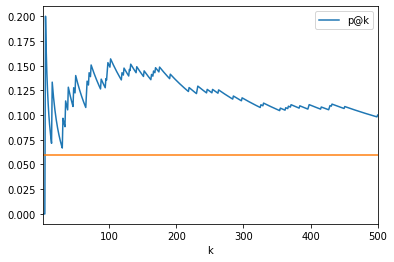

In [18]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure()
df[["k", "p@k"]][:500].plot(x="k", y= "p@k")
plt.plot(df[["k"]].values, np.full((len(df[["k"]]),1), 0.06))